#データの準備

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold as Kfold
from sklearn.preprocessing import LabelEncoder as le
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
pip install catboost scikit-learn

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submit.csv',header=None)

In [ ]:
trainX = train.drop(['id'],axis=1)
trainX.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,8.002,308.763915,140,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401
1,8.002,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679
2,4.002,95.382697,70,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575
3,4.002,133.990715,85,2315.158110,15.466768,76.038414,2.998,datsun 210 mpg,35.718788
4,8.002,328.254545,150,4219.526213,15.264577,75.238489,0.998,triumph tr7 coupe,17.415113


In [ ]:
trainX2 = train.drop(['id'],axis=1)
trainX2.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,8.002,308.763915,140,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401
1,8.002,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679
2,4.002,95.382697,70,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575
3,4.002,133.990715,85,2315.158110,15.466768,76.038414,2.998,datsun 210 mpg,35.718788
4,8.002,328.254545,150,4219.526213,15.264577,75.238489,0.998,triumph tr7 coupe,17.415113


In [ ]:
testX = test.copy()

In [ ]:
testX = testX.drop('id',axis=1)
testX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,4.002,97.502470,71,2722.792216,15.419528,76.434109,0.998000,chevrolet nova
1,4.002,132.430995,150,1794.227186,20.032104,76.774002,0.998000,vw rabbit
2,4.002,100.040582,150,2103.863515,13.415063,70.997969,0.998000,datsun pl510
3,6.002,400.452581,85,2722.502681,17.665557,71.431953,0.998000,chevrolet caprice classic
4,4.002,143.165887,90,3277.078489,15.517748,80.722361,0.998001,peugeot 505s turbo diesel
...,...,...,...,...,...,...,...,...
795,8.002,96.451159,139,2161.029110,13.275688,78.000769,0.998000,ford futura
796,4.002,85.945454,120,3782.447517,15.512737,77.593834,0.998001,dodge monaco brougham
797,6.002,225.189401,110,2761.638589,18.044362,80.959405,0.998001,dodge aspen
798,8.002,307.651448,130,2594.441523,13.166234,78.000912,0.998000,ford futura


In [ ]:
print('trainX:',trainX.shape)
print('testX:',testX.shape)

trainX: (1200, 9)
testX: (800, 8)


In [ ]:
print(trainX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     1200 non-null   float64
 1   displacement  1200 non-null   float64
 2   horsepower    1200 non-null   object 
 3   weight        1200 non-null   float64
 4   acceleration  1200 non-null   float64
 5   model year    1200 non-null   float64
 6   origin        1200 non-null   float64
 7   car name      1200 non-null   object 
 8   mpg           1200 non-null   float64
dtypes: float64(7), object(2)
memory usage: 84.5+ KB
None


In [ ]:
print(testX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     800 non-null    float64
 1   displacement  800 non-null    float64
 2   horsepower    800 non-null    object 
 3   weight        800 non-null    float64
 4   acceleration  800 non-null    float64
 5   model year    800 non-null    float64
 6   origin        800 non-null    float64
 7   car name      800 non-null    object 
dtypes: float64(6), object(2)
memory usage: 50.1+ KB
None


In [ ]:
#object型からfloat型へ変換
testX['horsepower'] = pd.to_numeric(testX['horsepower'],errors='coerce')
testX.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,4.002,97.502470,71.0,2722.792216,15.419528,76.434109,0.998000,chevrolet nova
1,4.002,132.430995,150.0,1794.227186,20.032104,76.774002,0.998000,vw rabbit
2,4.002,100.040582,150.0,2103.863515,13.415063,70.997969,0.998000,datsun pl510
3,6.002,400.452581,85.0,2722.502681,17.665557,71.431953,0.998000,chevrolet caprice classic
4,4.002,143.165887,90.0,3277.078489,15.517748,80.722361,0.998001,peugeot 505s turbo diesel


In [ ]:
trainX['horsepower'] = pd.to_numeric(trainX['horsepower'],errors='coerce')
trainX.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,8.002,308.763915,140.0,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401
1,8.002,421.557379,220.0,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679
2,4.002,95.382697,70.0,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575
3,4.002,133.990715,85.0,2315.158110,15.466768,76.038414,2.998,datsun 210 mpg,35.718788
4,8.002,328.254545,150.0,4219.526213,15.264577,75.238489,0.998,triumph tr7 coupe,17.415113


#Trainデータ　車名にラベルエンコーディング

In [ ]:
car_label = trainX.groupby(['car name']).count().reset_index()[['car name']]

In [ ]:
car_label.head()

,car name
0,amc gremlin
1,amc hornet
2,amc matador
3,audi 5000s (diesel)
4,buick century limited


#Testデータ　車名にラベルエンコーディング

In [ ]:
test_car = testX.groupby(['car name']).count().reset_index()[['car name']]

In [ ]:
test_car.head(10)

,car name
0,amc gremlin
1,amc hornet
2,amc matador
3,amc spirit dl
4,audi 5000s (diesel)
5,buick century limited
6,buick regal sport coupe (turbo)
7,buick skyhawk
8,capri ii
9,chevrolet caprice classic


#TestとTrainの車名を重複なしで抽出してラベルエンコーディング

In [ ]:
all_car = pd.merge(test_car,car_label,how='outer',on='car name' )

In [ ]:
all_car

,car name
0,amc gremlin
1,amc hornet
2,amc matador
3,amc spirit dl
4,audi 5000s (diesel)
5,buick century limited
6,buick regal sport coupe (turbo)
7,buick skyhawk
8,capri ii
9,chevrolet caprice classic


In [ ]:
all_car['car_label'] = le().fit_transform(all_car['car name'])
all_car

,car name,car_label
0,amc gremlin,0
1,amc hornet,1
2,amc matador,2
3,amc spirit dl,3
4,audi 5000s (diesel),4
5,buick century limited,5
6,buick regal sport coupe (turbo),6
7,buick skyhawk,7
8,capri ii,8
9,chevrolet caprice classic,9


In [ ]:
testX = pd.merge(testX,all_car,on='car name',how='left')
trainX = pd.merge(trainX,all_car,on='car name',how='left')

In [ ]:
testX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_label
0,4.002,97.502470,71.0,2722.792216,15.419528,76.434109,0.998000,chevrolet nova,11
1,4.002,132.430995,150.0,1794.227186,20.032104,76.774002,0.998000,vw rabbit,58
2,4.002,100.040582,150.0,2103.863515,13.415063,70.997969,0.998000,datsun pl510,21
3,6.002,400.452581,85.0,2722.502681,17.665557,71.431953,0.998000,chevrolet caprice classic,9
4,4.002,143.165887,90.0,3277.078489,15.517748,80.722361,0.998001,peugeot 505s turbo diesel,44
...,...,...,...,...,...,...,...,...,...
795,8.002,96.451159,139.0,2161.029110,13.275688,78.000769,0.998000,ford futura,29
796,4.002,85.945454,120.0,3782.447517,15.512737,77.593834,0.998001,dodge monaco brougham,25
797,6.002,225.189401,110.0,2761.638589,18.044362,80.959405,0.998001,dodge aspen,23
798,8.002,307.651448,130.0,2594.441523,13.166234,78.000912,0.998000,ford futura,29


#欠損値の補完

In [ ]:
print(trainX.isnull().sum())

cylinders        0
displacement     0
horsepower      45
weight           0
acceleration     0
model year       0
origin           0
car name         0
mpg              0
car_label        0
dtype: int64


In [ ]:
#馬力から欠損値処理
trainX[trainX['horsepower'].isnull()]

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,car_label
21,4.002000,136.387989,NaN,1744.279875,19.710619,77.235418,0.998000,vw rabbit,28.101575,58
25,4.002000,135.539071,NaN,1751.059518,20.306400,76.939121,0.998000,vw rabbit,28.283975,58
37,4.002000,87.654399,NaN,2148.975236,17.886957,81.611006,0.998000,ford pinto,44.603388,34
70,4.002000,136.116708,NaN,2132.183152,17.940433,82.135887,1.998000,datsun 200-sx,28.656581,14
71,4.002000,137.865761,NaN,1751.735284,19.521652,77.197102,0.998000,vw rabbit,28.147268,58
126,4.002000,88.007699,NaN,1761.821413,13.648001,82.306236,1.998000,dodge coronet custom,44.683589,24
174,4.002000,138.865333,NaN,1740.293446,19.212765,76.474551,0.998000,vw rabbit,28.938609,58
200,4.002000,137.564797,NaN,1759.888380,19.919907,77.115962,0.998000,vw rabbit,28.577867,58
238,4.002000,136.124672,NaN,1763.498926,20.037013,76.964672,0.998000,vw rabbit,28.534859,58
248,4.002000,128.037366,NaN,1749.863971,13.379489,71.255936,0.998000,vw rabbit,28.734163,58


In [ ]:
trainX['horsepower'] = trainX['horsepower'].fillna(0)#ゼロで埋めるのが精度が良い

In [ ]:
print(trainX.isnull().sum())

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
mpg             0
car_label       0
dtype: int64


In [ ]:
#train,test それぞれ確認
trainX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,car_label
0,8.002,308.763915,140.0,2682.667484,13.361159,79.000820,0.998000,mercury cougar brougham,17.786401,38
1,8.002,421.557379,220.0,2160.223156,9.672329,70.623025,0.998000,datsun 710,17.194679,19
2,4.002,95.382697,70.0,1861.752560,17.544130,81.416513,0.998000,peugeot 504,36.180575,43
3,4.002,133.990715,85.0,2315.158110,15.466768,76.038414,2.998000,datsun 210 mpg,35.718788,17
4,8.002,328.254545,150.0,4219.526213,15.264577,75.238489,0.998000,triumph tr7 coupe,17.415113,56
...,...,...,...,...,...,...,...,...,...,...
1195,4.002,136.963377,0.0,1776.224127,19.627257,77.063060,2.998000,honda civic 1300,34.975926,36
1196,8.002,305.828570,220.0,2679.623009,13.321090,79.000960,0.998000,amc matador,17.349570,2
1197,4.002,98.155555,70.0,1880.897429,15.126069,81.612070,0.998000,peugeot 504,36.057827,43
1198,4.002,88.291644,75.0,2827.505287,15.479811,71.785829,2.998001,dodge monaco brougham,27.781077,25


In [ ]:
testX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_label
0,4.002,97.502470,71.0,2722.792216,15.419528,76.434109,0.998000,chevrolet nova,11
1,4.002,132.430995,150.0,1794.227186,20.032104,76.774002,0.998000,vw rabbit,58
2,4.002,100.040582,150.0,2103.863515,13.415063,70.997969,0.998000,datsun pl510,21
3,6.002,400.452581,85.0,2722.502681,17.665557,71.431953,0.998000,chevrolet caprice classic,9
4,4.002,143.165887,90.0,3277.078489,15.517748,80.722361,0.998001,peugeot 505s turbo diesel,44
...,...,...,...,...,...,...,...,...,...
795,8.002,96.451159,139.0,2161.029110,13.275688,78.000769,0.998000,ford futura,29
796,4.002,85.945454,120.0,3782.447517,15.512737,77.593834,0.998001,dodge monaco brougham,25
797,6.002,225.189401,110.0,2761.638589,18.044362,80.959405,0.998001,dodge aspen,23
798,8.002,307.651448,130.0,2594.441523,13.166234,78.000912,0.998000,ford futura,29


#仕上げ

In [ ]:
#車名を落とす
trainX = trainX.drop(['car name'],axis=1)
testX = testX.drop(['car name'],axis=1)
trainX.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car_label
0,8.002,308.763915,140.0,2682.667484,13.361159,79.000820,0.998,17.786401,38
1,8.002,421.557379,220.0,2160.223156,9.672329,70.623025,0.998,17.194679,19
2,4.002,95.382697,70.0,1861.752560,17.544130,81.416513,0.998,36.180575,43
3,4.002,133.990715,85.0,2315.158110,15.466768,76.038414,2.998,35.718788,17
4,8.002,328.254545,150.0,4219.526213,15.264577,75.238489,0.998,17.415113,56


#データを可視化

In [ ]:
trainX.describe()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car_label
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,5.270333,187.559264,103.467500,2616.812746,15.193847,77.505178,1.332167,27.475247,31.586667
std,1.664423,107.757619,41.957092,695.581408,2.109699,3.798780,0.699696,7.521617,15.990275
min,4.001984,82.776322,0.000000,1714.444811,9.565413,70.314473,0.998000,16.935547,0.000000
25%,4.002000,97.650597,71.000000,2103.568450,13.402584,75.383890,0.998000,22.700008,19.000000
50%,4.002000,137.141540,97.000000,2304.023111,15.153402,77.999984,0.998000,27.689721,34.000000
75%,6.002000,307.918863,139.000000,3171.560209,15.550417,81.474235,0.998002,35.855009,43.000000
max,8.002000,425.284954,220.000000,4632.432969,21.498304,82.327672,2.998006,45.076959,59.000000


In [ ]:
testX.describe()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_label
count,800.000000,800.000000,779.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5.251999,184.182866,105.96534,2628.780538,15.164779,77.404968,1.336751,32.222500
std,1.643434,102.945388,35.03733,722.912221,2.015075,3.764576,0.701508,16.016746
min,4.001979,82.270213,58.00000,1729.042016,9.617850,70.406718,0.998000,0.000000
25%,4.002000,97.868516,71.00000,2097.540937,13.415269,75.115285,0.998000,20.000000
50%,4.002000,136.986702,97.00000,2304.105470,15.151767,77.633062,0.998000,34.000000
75%,6.002000,302.176235,139.00000,3170.993934,15.525051,81.401812,0.998002,44.000000
max,8.002000,424.325205,220.00000,4413.793649,21.446851,82.317980,2.998008,59.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df2e33550>,
      dtype=object)

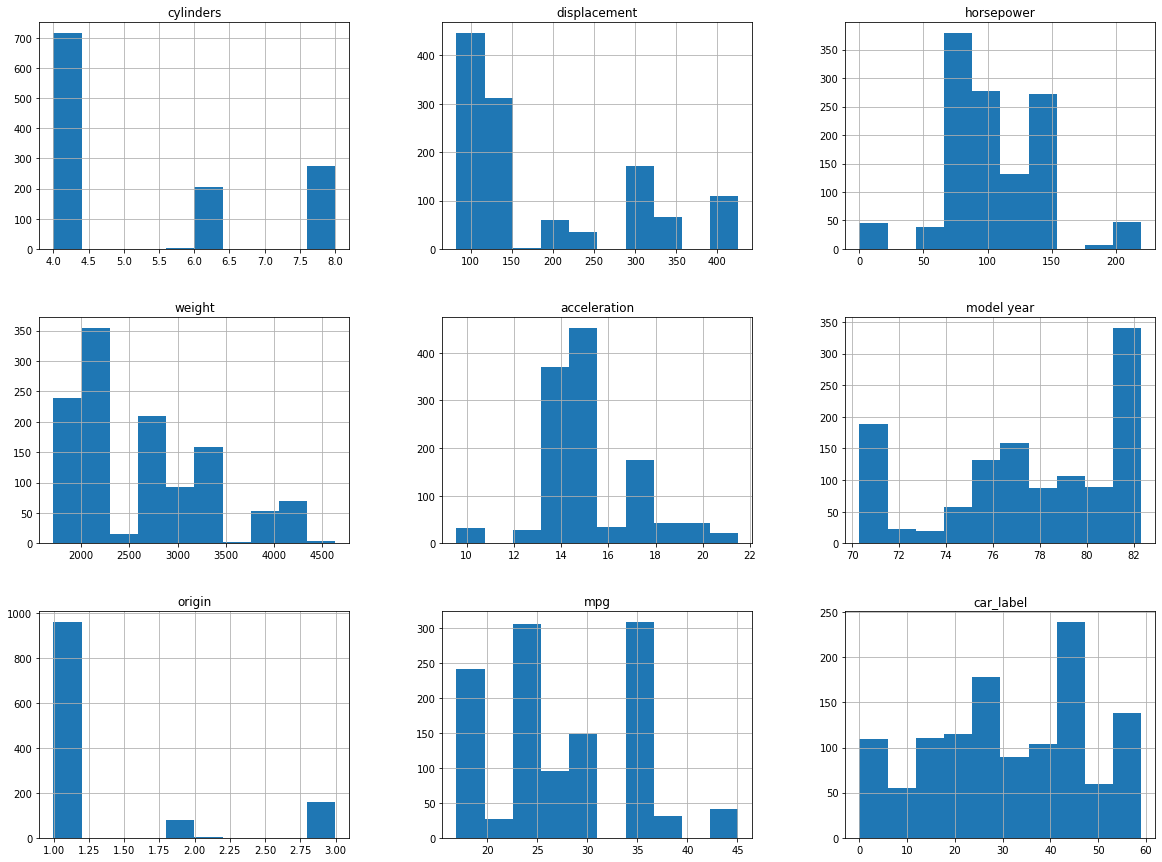

In [ ]:
trainX.hist(bins=10,figsize=(20,15))

In [ ]:
df = pd.DataFrame(trainX)

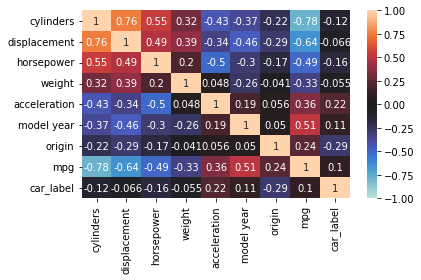

In [ ]:
train_corr = trainX.corr()#各列間の相関関係を算出
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 58.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


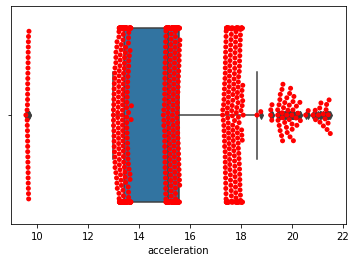

<Figure size 1440x1080 with 0 Axes>

In [ ]:
sns.boxplot(df['acceleration'])
sns.swarmplot(df['acceleration'],color='r')
plt.figure(figsize=(20,15))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


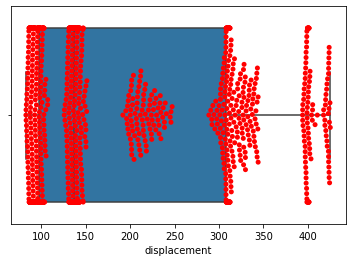

<Figure size 1440x1080 with 0 Axes>

In [ ]:
sns.boxplot(df['displacement'])
sns.swarmplot(df['displacement'],color='r')
plt.figure(figsize=(20,15))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


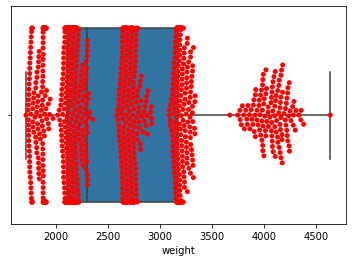

<Figure size 1440x1080 with 0 Axes>

In [ ]:
sns.boxplot(df['weight'])
sns.swarmplot(df['weight'],color='r')
plt.figure(figsize=(20,15))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


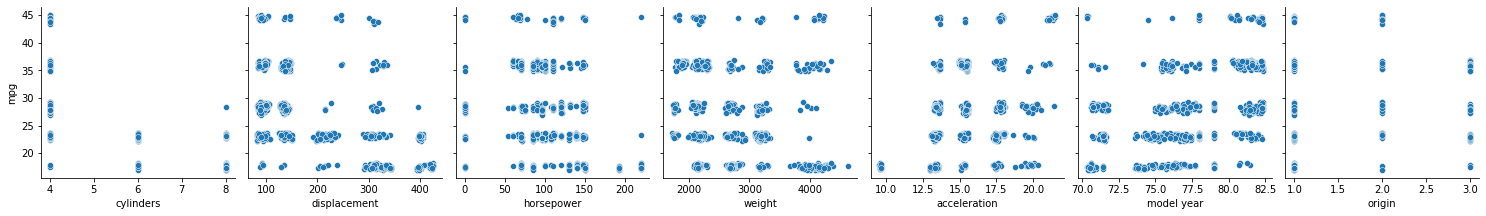

In [ ]:
sns.pairplot(df,y_vars=['mpg'],x_vars=['cylinders','displacement','horsepower','weight','acceleration','model year','origin'],size=3)

#binning 数値変数を区間ごとにグループ分け

In [ ]:
trainX['weight'].describe()

count    1200.000000
mean     2616.812746
std       695.581408
min      1714.444811
25%      2103.568450
50%      2304.023111
75%      3171.560209
max      4632.432969
Name: weight, dtype: float64

In [ ]:
x = trainX['weight']

In [ ]:
x

0       2682.667484
1       2160.223156
2       1861.752560
3       2315.158110
4       4219.526213
           ...     
1195    1776.224127
1196    2679.623009
1197    1880.897429
1198    2827.505287
1199    3209.951299
Name: weight, Length: 1200, dtype: float64

In [ ]:
bin_edges = [-float('inf'),2304.0,3172.0,float('inf')]

In [ ]:
binned = pd.cut(x,bin_edges,labels=False)

In [ ]:
binned.head()

0    1
1    0
2    0
3    1
4    2
Name: weight, dtype: int64

In [ ]:
binned = pd.DataFrame(binned)

In [ ]:
binned = binned.rename(columns={'weight':'weight_cat'})

In [ ]:
trainX2 = pd.concat([trainX,binned],axis=1)

In [ ]:
trainX2

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car_label,weight_cat
0,8.002,308.763915,140.0,2682.667484,13.361159,79.000820,0.998000,17.786401,38,1
1,8.002,421.557379,220.0,2160.223156,9.672329,70.623025,0.998000,17.194679,19,0
2,4.002,95.382697,70.0,1861.752560,17.544130,81.416513,0.998000,36.180575,43,0
3,4.002,133.990715,85.0,2315.158110,15.466768,76.038414,2.998000,35.718788,17,1
4,8.002,328.254545,150.0,4219.526213,15.264577,75.238489,0.998000,17.415113,56,2
...,...,...,...,...,...,...,...,...,...,...
1195,4.002,136.963377,0.0,1776.224127,19.627257,77.063060,2.998000,34.975926,36,0
1196,8.002,305.828570,220.0,2679.623009,13.321090,79.000960,0.998000,17.349570,2,1
1197,4.002,98.155555,70.0,1880.897429,15.126069,81.612070,0.998000,36.057827,43,0
1198,4.002,88.291644,75.0,2827.505287,15.479811,71.785829,2.998001,27.781077,25,1


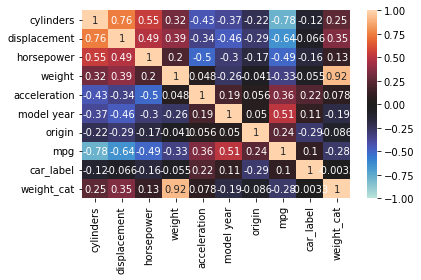

In [ ]:
train_corr = trainX2.corr()#各列間の相関関係を算出
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
t = testX['weight']

In [ ]:
binned = pd.cut(t,bin_edges,labels=False)

In [ ]:
binned = pd.DataFrame(binned)

In [ ]:
binned = binned.rename(columns={'weight':'weight_cat'})

In [ ]:
testX = pd.concat([testX,binned],axis=1)

In [ ]:
testX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car_label,weight_cat
0,4.002,97.502470,71.0,2722.792216,15.419528,76.434109,0.998000,11,1
1,4.002,132.430995,150.0,1794.227186,20.032104,76.774002,0.998000,58,0
2,4.002,100.040582,150.0,2103.863515,13.415063,70.997969,0.998000,21,0
3,6.002,400.452581,85.0,2722.502681,17.665557,71.431953,0.998000,9,1
4,4.002,143.165887,90.0,3277.078489,15.517748,80.722361,0.998001,44,2
...,...,...,...,...,...,...,...,...,...
795,8.002,96.451159,139.0,2161.029110,13.275688,78.000769,0.998000,29,0
796,4.002,85.945454,120.0,3782.447517,15.512737,77.593834,0.998001,25,2
797,6.002,225.189401,110.0,2761.638589,18.044362,80.959405,0.998001,23,1
798,8.002,307.651448,130.0,2594.441523,13.166234,78.000912,0.998000,29,1


#標準化 (回帰分析などで効果あり)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std = StandardScaler()
std.fit(trainX2[['acceleration']])

StandardScaler()

In [ ]:
trainX2['acceleration_std'] = std.transform(trainX2[['acceleration']])

In [ ]:
trainX2['acceleration_std'].head()

0   -0.869059
1   -2.618298
2    1.114501
3    0.129419
4    0.033540
Name: acceleration_std, dtype: float64

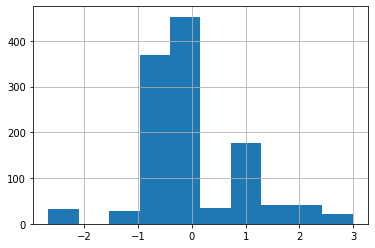

In [ ]:
trainX2['acceleration_std'].hist(bins=10)

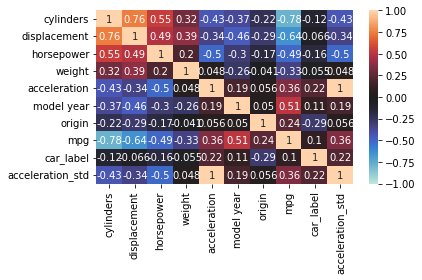

In [ ]:
train_corr = trainX.corr()#各列間の相関関係を算出
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
trainX['acceleration_std_log'] = trainX['acceleration_std'].apply(np.log1p)

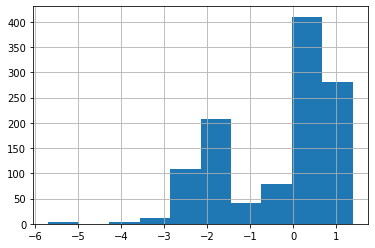

In [ ]:
trainX['acceleration_std_log'].hist(bins=10)

#対数関数化

In [ ]:
trainX['displacement_log'] = trainX['displacement'].apply(np.log1p)
trainX['acceleration_log'] = trainX['acceleration'].apply(np.log1p)

In [ ]:
trainX2['displacement_log'] = trainX2['displacement'].apply(np.log1p)
trainX2['acceleration_log'] = trainX2['acceleration'].apply(np.log1p)

In [ ]:
trainX

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg,car_label,displacement_log,acceleration_log
0,8.002,308.763915,140.0,2682.667484,13.361159,79.000820,0.998000,17.786401,38,5.735810,2.664527
1,8.002,421.557379,220.0,2160.223156,9.672329,70.623025,0.998000,17.194679,19,6.046325,2.367654
2,4.002,95.382697,70.0,1861.752560,17.544130,81.416513,0.998000,36.180575,43,4.568327,2.920153
3,4.002,133.990715,85.0,2315.158110,15.466768,76.038414,2.998000,35.718788,17,4.905206,2.801344
4,8.002,328.254545,150.0,4219.526213,15.264577,75.238489,0.998000,17.415113,56,5.796831,2.788990
...,...,...,...,...,...,...,...,...,...,...,...
1195,4.002,136.963377,0.0,1776.224127,19.627257,77.063060,2.998000,34.975926,36,4.926988,3.026613
1196,8.002,305.828570,220.0,2679.623009,13.321090,79.000960,0.998000,17.349570,2,5.726289,2.661733
1197,4.002,98.155555,70.0,1880.897429,15.126069,81.612070,0.998000,36.057827,43,4.596690,2.780437
1198,4.002,88.291644,75.0,2827.505287,15.479811,71.785829,2.998001,27.781077,25,4.491908,2.802136


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6dea0e8390>,
      dtype=object)

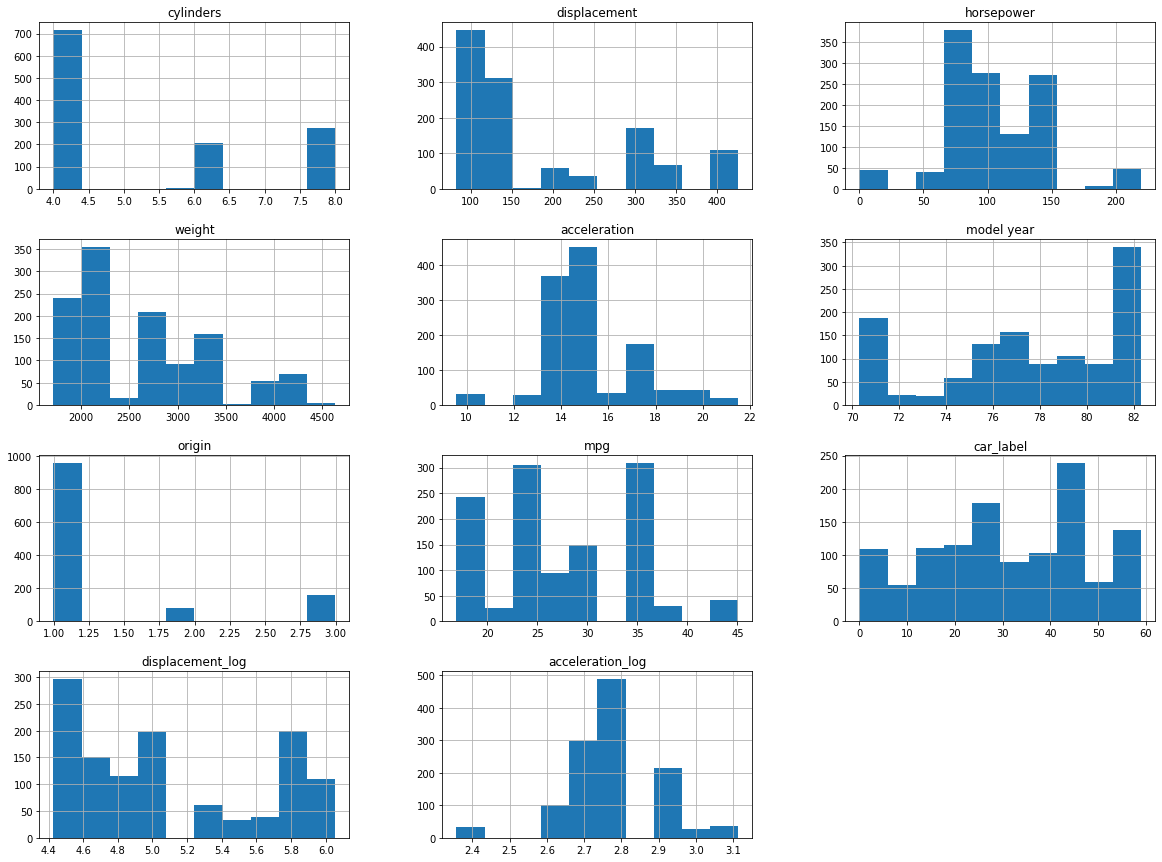

In [ ]:
trainX.hist(bins=10,figsize=(20,15))

In [ ]:
testX['displacement_log'] = testX['displacement'].apply(np.log1p)
testX['acceleration_log'] = testX['acceleration'].apply(np.log1p)
#testX['weight_log'] = testX['weight'].apply(np.log1p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df27b7710>,
      dtype=object)

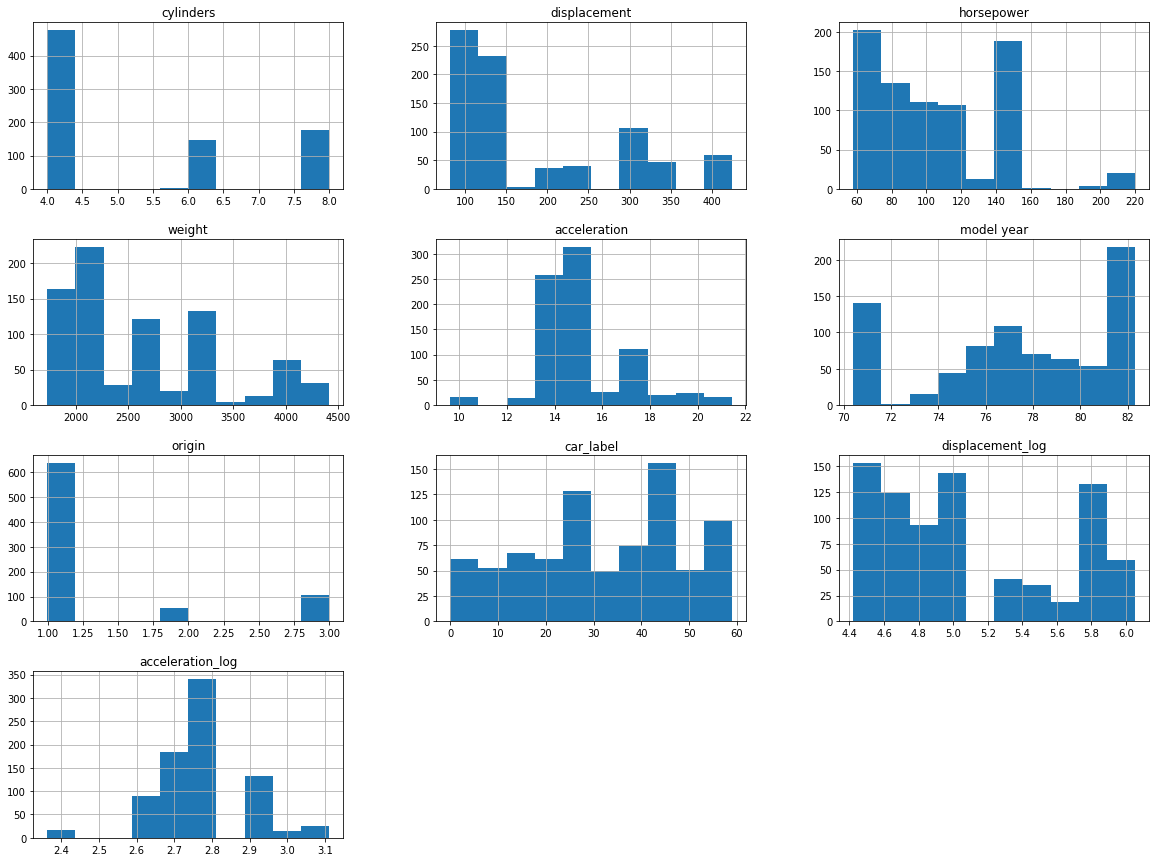

In [ ]:
testX.hist(bins=10,figsize=(20,15))

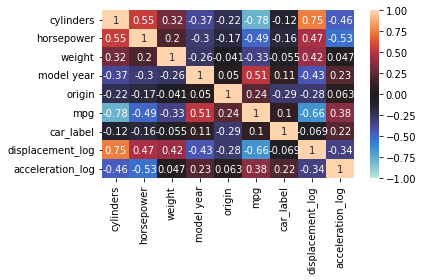

In [ ]:
train_corr = trainX.corr()#各列間の相関関係を算出
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
print(trainX.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cylinders         1200 non-null   float64
 1   horsepower        1200 non-null   float64
 2   weight            1200 non-null   float64
 3   model year        1200 non-null   float64
 4   origin            1200 non-null   float64
 5   mpg               1200 non-null   float64
 6   car_label         1200 non-null   int64  
 7   displacement_log  1200 non-null   float64
 8   acceleration_log  1200 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 93.8 KB
None


In [ ]:
trainX = trainX.drop(columns=['acceleration','displacement'],axis=1)
testX = testX.drop(columns=['acceleration','displacement'],axis=1)

#データセット

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(trainX,trainX['mpg'],test_size=0.3,random_state=42)
#df_train,df_val

In [ ]:
#学習データとテストデータに分ける
X_train = X_train.drop('mpg',axis=1)
X_test = X_test.drop('mpg',axis=1)
#y_train = df_train['mpg']
#y_test = df_val['mpg']

In [ ]:
#学習データを、学習用と検証用にわける
X_train,X_eval,y_train,y_eval = train_test_split(X_train,y_train,test_size=0.3,random_state=42)

In [ ]:
# 各4つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各4つのモデルの正答率を保存するリストの初期化
xgb_scores = []
lgbm_scores = []
catb_scores = []

#LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [ ]:
#df_train,df_val = train_test_split(trainX,test_size=0.3)

In [ ]:
#X_train = df_train.drop('mpg',axis=1)
#X_valid = df_val.drop('mpg',axis=1)
#y_train = df_train['mpg']
#y_valid = df_val['mpg']

In [ ]:
trains = lgb.Dataset(X_train,label = y_train)
evals = lgb.Dataset(X_eval,label =y_eval)

In [ ]:
evaluation_results={}

In [ ]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
}

In [ ]:
lgb_m = lgb.train(params, trains, valid_sets=evals,evals_result=evaluation_results ,num_boost_round=200, early_stopping_rounds=30)

[1]	valid_0's rmse: 7.09456
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 6.57822
[3]	valid_0's rmse: 6.13776
[4]	valid_0's rmse: 5.74072
[5]	valid_0's rmse: 5.40483
[6]	valid_0's rmse: 5.1039
[7]	valid_0's rmse: 4.87721
[8]	valid_0's rmse: 4.65037
[9]	valid_0's rmse: 4.45259
[10]	valid_0's rmse: 4.29478
[11]	valid_0's rmse: 4.14364
[12]	valid_0's rmse: 4.02094
[13]	valid_0's rmse: 3.9097
[14]	valid_0's rmse: 3.82597
[15]	valid_0's rmse: 3.74642
[16]	valid_0's rmse: 3.68597
[17]	valid_0's rmse: 3.62873
[18]	valid_0's rmse: 3.57461
[19]	valid_0's rmse: 3.53506
[20]	valid_0's rmse: 3.49178
[21]	valid_0's rmse: 3.45332
[22]	valid_0's rmse: 3.42926
[23]	valid_0's rmse: 3.41223
[24]	valid_0's rmse: 3.40334
[25]	valid_0's rmse: 3.39233
[26]	valid_0's rmse: 3.38642
[27]	valid_0's rmse: 3.37773
[28]	valid_0's rmse: 3.36941
[29]	valid_0's rmse: 3.36518
[30]	valid_0's rmse: 3.35146
[31]	valid_0's rmse: 3.34682
[32]	valid_0's rmse: 3.33528
[33]	valid_0's rmse: 

In [ ]:
#df_test = testX

In [ ]:
pred1 = lgb_m.predict(X_eval)

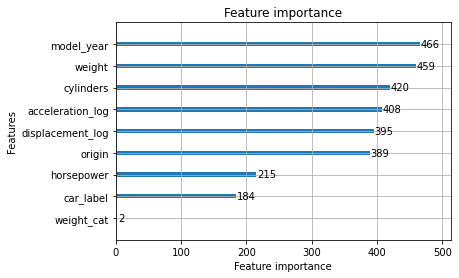

In [ ]:
lgb.plot_importance(lgb_m)

In [ ]:
pred1.max()

43.2488941191983

#XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
#listX = trainX.drop('mpg',axis=1)

In [ ]:
#y = trainX['mpg'].astype(int)

In [ ]:
evals_result = {}

In [ ]:
dtrain = xgb.DMatrix(X_train,label = y_train)
dvalid = xgb.DMatrix(X_eval,label =y_eval)

In [ ]:
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

In [ ]:
xgb_m = xgb.train(
      params = params,
     dtrain = dtrain,
     num_boost_round=100,
     early_stopping_rounds=10,
     evals_result=evals_result, 
     evals = [(dtrain, 'train'), (dvalid, 'valid')]
)

[0]	train-rmse:19.8969	valid-rmse:20.3332
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:14.1858	valid-rmse:14.7189
[2]	train-rmse:10.2086	valid-rmse:10.8008
[3]	train-rmse:7.41404	valid-rmse:8.21683
[4]	train-rmse:5.48721	valid-rmse:6.42619
[5]	train-rmse:4.17801	valid-rmse:5.28113
[6]	train-rmse:3.23334	valid-rmse:4.53913
[7]	train-rmse:2.60582	valid-rmse:4.10605
[8]	train-rmse:2.2525	valid-rmse:3.84331
[9]	train-rmse:1.93313	valid-rmse:3.72332
[10]	train-rmse:1.74959	valid-rmse:3.63161
[11]	train-rmse:1.56257	valid-rmse:3.59509
[12]	train-rmse:1.4406	valid-rmse:3.52738
[13]	train-rmse:1.37565	valid-rmse:3.50632
[14]	train-rmse:1.33678	valid-rmse:3.50633
[15]	train-rmse:1.3318	valid-rmse:3.49808
[16]	train-rmse:1.32934	valid-rmse:3.49268
[17]	train-rmse:1.32814	valid-rmse:3.4891
[18]	train-rmse:1.32754	valid-rmse:3.48668
[19]	train-rmse:1.32725	valid-rmse:3.48503
[20]	trai

In [ ]:
pred2 = xgb_m.predict(xgb.DMatrix(X_eval))
print(pred2)

[18.024021 35.718323 22.59124  22.424686 36.356297 34.52254  22.604116
 18.470171 18.198788 36.935974 36.356297 29.328335 31.3996   36.356297
 21.966404 29.743158 25.837538 34.995064 26.090397 36.356297 24.680708
 22.680828 28.51744  17.832466 32.261063 24.126083 40.654335 34.795322
 22.490011 26.92697  17.832466 23.077244 24.73888  17.687336 27.380974
 16.844175 26.951656 26.770006 23.077244 29.965595 27.959846 36.356297
 27.652546 34.3183   17.687336 36.356297 22.713728 22.172285 35.890194
 36.356297 29.353722 40.10604  26.828812 28.3151   34.77018  33.345413
 34.795322 22.664743 33.848442 34.986797 18.198788 22.845894 29.2327
 22.570778 18.542124 22.678274 25.221586 36.356297 22.556297 18.198788
 22.490011 30.066814 25.05871  18.966854 30.398495 32.791348 34.081474
 36.356297 27.189857 32.13517  22.9317   31.449467 28.386305 34.795322
 18.44357  18.775373 18.588572 30.30906  18.088081 24.445074 36.356297
 17.749432 18.782278 36.356297 23.355892 36.356297 36.356297 21.352238
 36.3562

In [ ]:
#submit.iloc[:,-1] = pred2
#submit.head()

In [ ]:
#submit.to_csv('car_sub2.csv',index=False,header=False)

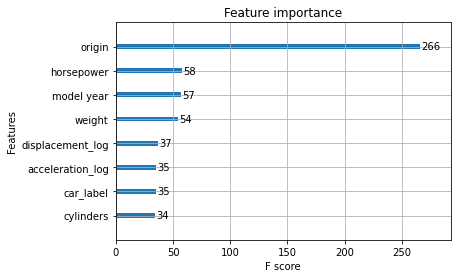

In [ ]:
xgb.plot_importance(xgb_m)

In [ ]:
pred2.max()

43.914917

#CatBoosting

In [ ]:
from catboost import CatBoost as cat
from catboost import CatBoostClassifier,CatBoostRegressor
from catboost import Pool
import numpy as np

In [ ]:
cat_train = Pool(X_train,label=y_train)
cat_eval = Pool(X_eval,label=y_eval)

In [ ]:
params = {        
        'num_boost_round': 100,          # 学習の回数
        'early_stopping_rounds': 10       # アーリーストッピングの回数
}

In [ ]:
catb = cat(params)
catb.fit(cat_train,eval_set=[cat_eval],,verbose=False)

In [ ]:
pred3 = catb.predict(X_eval)
pred3

array([18.25934914, 34.36775073, 22.40966194, 23.37349739, 36.09197863,
       35.86205666, 21.1196832 , 18.85432031, 18.26341471, 37.82466904,
       36.37336694, 30.44553887, 30.02237624, 36.29235205, 23.3439621 ,
       29.06970963, 28.05680298, 33.11879047, 28.54316361, 36.28289269,
       25.57637969, 21.51398697, 27.68048678, 17.85271875, 32.45633274,
       32.25693541, 38.65917136, 34.36232885, 21.50210197, 26.14496653,
       17.6590547 , 22.97849262, 24.91655336, 17.62860853, 27.93938995,
       17.960844  , 25.76122615, 25.92920982, 22.59860179, 25.74747486,
       30.31677056, 35.7576643 , 28.94618634, 33.15689314, 17.74714493,
       36.40632706, 22.75072959, 22.25299725, 36.99361074, 36.21964141,
       29.72469713, 40.75211335, 28.46241456, 27.85840028, 32.64973731,
       34.84083839, 34.02503147, 21.66133632, 30.48539637, 34.60537228,
       18.61404397, 22.22256291, 29.41128329, 22.297259  , 21.27498969,
       22.12188267, 25.97537922, 36.40632706, 22.33619011, 18.63

In [ ]:
pred3.max()

42.68114434816186

#スタッキング

In [ ]:
# 第1段階の予測値(この後、メタモデルの入力に使用)
first_pred_1 = lgb_m.predict(X_test)
first_pred_3 = catb.predict(X_test)
first_pred_2 = xgb_m.predict(xgb.DMatrix(X_test))

In [ ]:
#第1段階の予測値を積み重ねる
stack_pred = np.column_stack((first_pred_1, first_pred_2, first_pred_3))

In [ ]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor as rfr

In [ ]:
#メタモデルの作成
meta = lr()
meta.fit(stack_pred,y_test)

meta2 = Ridge()#精度ちょっと上がる
meta2.fit(stack_pred,y_test) 

Ridge()

In [ ]:
#meta3 = rfr()
#meta3.fit(stack_pred,y_test)

RandomForestRegressor()

In [ ]:
test_pred1 = lgb_m.predict(testX)
test_pred2 = xgb_m.predict(xgb.DMatrix(testX))
test_pred3 = catb.predict(testX)

In [ ]:
stack_test_pred = np.column_stack((test_pred1, test_pred2, test_pred3))

In [ ]:
bst = meta.predict(stack_test_pred)
bst2 = meta2.predict(stack_test_pred)

In [ ]:
bst.max()

44.19910227894289

In [ ]:
bst2.max()

44.19836906131921

In [ ]:
submit.iloc[:,-1] = bst2
submit.head()

,0,1
0,1200,29.931418
1,1201,24.490737
2,1202,28.331292
3,1203,22.032485
4,1204,32.116120


In [ ]:
submit.to_csv('car_submit.csv',index=False,header=False)